# Sentiment Analysis of characters of Treasure Island

## Load and Clean the Text

### Loading All the necessary libraries

In [1]:
# Standard Library Imports 
import re
import math
import random
from collections import Counter

# Data Handling & Visualization 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries 
import nltk
import spacy
import coreferee
from nltk.tokenize import sent_tokenize, word_tokenize

# Web Requests
import requests

# Jupyter Notebook Setup
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


### Remove unwanted parts (like copyright boilerplates). Keeping only the main narrative.

In [2]:
# Load and clean the text
with open("treasure_island.txt", "r", encoding="utf-8") as f:
    text = f.read()

start_marker = "PART ONE--The Old Buccaneer"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK TREASURE ISLAND ***"

start = text.find(start_marker)
end = text.find(end_marker)
cleaned_text = text[start:end]

with open("cleaned_treasure_island.txt", "w", encoding="utf-8") as f:
    f.write(cleaned_text)

print(f"Length of cleaned text: {len(cleaned_text):,} characters")

Length of cleaned text: 368,233 characters


In [3]:
# Show top of the cleaned text
print("***First 1000 characters of cleaned text:***\n")
print(cleaned_text[:1000])

# Divider
print("\n" + "="*80 + "\n")

# Show end of the cleaned text
print("***Last 1000 characters of cleaned text:***\n")
print(cleaned_text[-1000:])


***First 1000 characters of cleaned text:***

PART ONE--The Old Buccaneer









I

The Old Sea-dog at the Admiral Benbow





Squire Trelawney, Dr. Livesey, and the rest of these gentlemen having

asked me to write down the whole particulars about Treasure Island, from

the beginning to the end, keeping nothing back but the bearings of the

island, and that only because there is still treasure not yet lifted, I

take up my pen in the year of grace 17—, and go back to the time when

my father kept the Admiral Benbow inn and the brown old seaman with the

sabre cut first took up his lodging under our roof.



I remember him as if it were yesterday, as he came plodding to the

inn door, his sea-chest following behind him in a hand-barrow--a

tall, strong, heavy, nut-brown man, his tarry pigtail falling over the

shoulder of his soiled blue coat, his hands ragged and scarred, with

black, broken nails, and the sabre cut across one cheek, a dirty, livid

white. I remember him looking rou

## Text Segmentation and Sentence Tokenization

### Chapter Segmentation Using Regular Expressions

Gutenberg books often use double newlines and chapter numerals.

The regex captures those transitions without breaking on sentences or headings that just happen to contain Roman numerals.

In [4]:
# Chapter Segmentation
def split_chapters(text):
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    chapter_starts = list(re.finditer(r'\n+[IVXLCDM]+\n.*?\n', text))
    chapters = []
    for i in range(len(chapter_starts)):
        start_pos = chapter_starts[i].start()
        end_pos = chapter_starts[i + 1].start() if i + 1 < len(chapter_starts) else len(text)
        chapter_text = text[start_pos:end_pos].strip()
        match = re.match(r'\n*([IVXLCDM]+)\n(.*?)\n(.*)', chapter_text, re.DOTALL)
        if match:
            num = match.group(1)
            title = match.group(2).strip()
            content = match.group(3).strip()
            if len(content) > 50:
                chapters.append(f"{num}\n{title}\n\n{content}")
    return chapters

chapters = split_chapters(cleaned_text)

# Show chapter numbers and titles
for i, chap in enumerate(chapters):
    lines = chap.split('\n')
    print(f"Chapter {lines[0]}: {lines[1]}")


Chapter I: 
Chapter II: 
Chapter III: 
Chapter IV: 
Chapter V: 
Chapter VI: 
Chapter VII: 
Chapter VIII: 
Chapter IX: 
Chapter X: 
Chapter XI: 
Chapter XII: 
Chapter XIII: 
Chapter XIV: 
Chapter XV: 
Chapter XVI: 
Chapter XXVII: 
Chapter XVIII: 
Chapter XIX: 
Chapter XX: 
Chapter XXI: 
Chapter XXII: 
Chapter XXIII: 
Chapter XXIV: 
Chapter XXV: 
Chapter XXVI: 
Chapter XXVII: 
Chapter XXVIII: 
Chapter XXIX: 
Chapter XXX: 
Chapter XXXI: 
Chapter XXXII: 
Chapter XXXIII: 
Chapter XXXIV: 


In [5]:
# Coreference Resolution
nlp = spacy.load("en_core_web_trf")
nlp.add_pipe("coreferee")


def resolve_coref(text):
    doc = nlp(text)
    resolved = text
    if doc._.coref_chains:
        replacements = []
        for chain in doc._.coref_chains:
            main = doc[chain[0].token_indexes[0]:chain[0].token_indexes[-1] + 1].text
            for mention in chain[1:]:
                mention_text = doc[mention.token_indexes[0]:mention.token_indexes[-1] + 1].text
                if mention_text.lower() != main.lower():
                    replacements.append((mention_text, main))
        for mention_text, main in sorted(set(replacements), key=lambda x: -len(x[0])):
            mention_pattern = r'(?<!\w)' + re.escape(mention_text) + r'(?!\w)'
            resolved = re.sub(mention_pattern, main, resolved)
    return resolved

resolved_chapters = [resolve_coref(chap) for chap in chapters]

### Sentence Tokenisation with spaCy

In [6]:
# Sentence Tokenization
chapter_data = []

for chap_index, (orig, resolved) in enumerate(zip(chapters, resolved_chapters)):
    doc_original = nlp(orig)
    doc_resolved = nlp(resolved)
    original_sentences = [sent.text.strip() for sent in doc_original.sents]
    resolved_sentences = [sent.text.replace('\n', ' ').strip() for sent in doc_resolved.sents]
    min_len = min(len(original_sentences), len(resolved_sentences))
    for i in range(min_len):
        chapter_data.append({
            "Chapter": chap_index + 1,
            "Original_Sentence": original_sentences[i],
            "Sentence": resolved_sentences[i]
        })

sent_df = pd.DataFrame(chapter_data)

In [7]:
# Pronoun Count Check
pronoun_pattern = r'\b(?:he|she|his|her|him|they|them|their|the boy|the man|the doctor|the cook|the captain)\b'
count_before = sum(sent_df["Original_Sentence"].str.contains(pronoun_pattern, case=False, regex=True))
count_after = sum(sent_df["Sentence"].str.contains(pronoun_pattern, case=False, regex=True))
print(f"Sentences with pronouns BEFORE coref: {count_before}")
print(f"Sentences with pronouns AFTER coref:  {count_after}")

Sentences with pronouns BEFORE coref: 1590
Sentences with pronouns AFTER coref:  287


## Named Entity Recognition (NER) and Character Mention Extraction

In [8]:
# Named Entity Recognition
all_mentions = []
for sentence in sent_df["Sentence"]:
    doc = nlp(sentence)
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            cleaned = ent.text.lower().replace("'s", "").strip()
            all_mentions.append(cleaned)

mention_counts = Counter(all_mentions)
mention_df = pd.DataFrame(mention_counts.items(), columns=["Name", "Mentions"]).sort_values(by="Mentions", ascending=False)
print("Total unique PERSON mentions:", len(mention_df))
pd.set_option('display.max_rows', None)
print(mention_df)


Total unique PERSON mentions: 145
                      Name  Mentions
41                  silver       389
53                    john       207
1                  livesey       166
59                smollett       125
115                o’brien       104
10                 hawkins       102
9                      jim        86
73                    dick        62
5                     bill        59
92                    gray        57
34                  hunter        56
13                   flint        41
134                  merry        41
50               trelawney        38
52                     dog        37
118                 george        35
35                 blandly        35
2                   benbow        35
84                ben gunn        35
38              hispaniola        34
77                   hands        30
46                   arrow        30
114                  inlet        26
57                  morgan        24
49                     tom        23
42  

###   Alias Mapping and Character Assignment

Characters list from "https://www.sparknotes.com/lit/treasure/characters/"

In [9]:

alias_to_canonical = {}
ner_merge_map = {
    "Jim Hawkins": [
        "jim", "hawkins", "jim hawkins", "james hawkins", "hawkin",
        "jim  hawkins", "jim hawkins’"
    ],
    "Long John Silver": [
        "silver", "long john", "john silver", "long john silver", "’s john silver", "john’s",
        "john  silver", "long john’s"
    ],
    "Dr. David Livesey": [
        "livesey", "livesey’s", "dr. livesey", "david livesey", "doctor livesey", "dr",
        "livesey--", "livesey shoulder", "livesey maker"
    ],
    "Squire Trelawney": [
        "trelawney", "squire trelawney", "john trelawney", "john      trelawney",
        "trelawney’s", "squire trelawney’s"
    ],
    "Captain Smollett": [
        "smollett", "alexander smollett", "alexander  smollett", "cap’n smollett", "smollett smollett"
    ],
    "Ben Gunn": [
        "ben gunn", "benjamin gunn", "ben gunn’s", "ben", "gunn", "--ben gunn’s",
        "ben  gunn", "ben gunn gunn", "ben  gunn’s"
    ],
    "Billy Bones": [
        "bill", "billy", "billy bones", "billy bones’s", "bones--", "w. bones",
        "billy  bones", "billy bones bill", "bill  lancet"
    ],
    "Captain Flint": [
        "flint"
    ],
    "George Merry": [
        "george merry", "george", "merry", "george  merry"
    ],
    "Israel Hands": [
        "israel hands"
    ],
    "Tom": [
        "tom"
    ],
    "Tom Morgan": [
        "tom morgan", "morgan"
    ],
    "Tom Redruth": [
        "tom redruth", "redruth", "thomas redruth", "redruth royal highness"
    ],
    "Hunter": [
        "hunter", "john hunter"
    ],
    "Joyce": [
        "joyce", "richard joyce"
    ],
    "Dick Johnson": [
        "dick", "dick’s", "dick johnson"
    ],
    "Job Anderson": [
        "anderson", "job anderson"
    ],
    "Abraham Gray": [
        "gray", "abraham gray", "abe gray", "abe gray--"
    ],
    "Alan": [
        "alan"
    ],
    "Dance": [
        "dance", "supervisor dance"
    ],
    "Arrow": [
        "arrow"
    ]
}


In [10]:

for canonical, aliases in ner_merge_map.items():
    for alias in sorted(aliases, key=lambda x: -len(x)):
        alias_to_canonical[alias.lower()] = canonical

def get_characters_from_sentence(sentence):
    characters_found = set()
    lower_sentence = sentence.lower()
    for alias, canonical in alias_to_canonical.items():
        alias_clean = re.escape(alias)
        if re.search(rf'(?<!\w){alias_clean}(?!\w)', lower_sentence):
            characters_found.add(canonical)
    return list(characters_found)

sent_df["Characters"] = sent_df["Sentence"].apply(get_characters_from_sentence)
print(sent_df[sent_df["Characters"].map(len) > 0].head(50))


     Chapter                                  Original_Sentence  \
0          1  I\n\n\nThe Old Sea-dog at the Admiral Benbow\n...   
1          1  I remember him as if it were yesterday, as he ...   
2          1  I remember him looking round the cove and whis...   
4          1  This, when it was brought to him,\n\nhe drank ...   
7          1                                                      
17         1  And indeed bad as his clothes were and coarsel...   
21         1                He was a very silent man by custom.   
23         1  Mostly\n\nhe would not speak when spoken to, o...   
24         1  Every day when he came back\n\nfrom his stroll...   
26         1  When a seaman did put up at the Admiral Benbow...   
27         1  For me, at least, there was no secret about th...   
29         1  Often enough when the first\n\nof the month ca...   
31         1  On\n\nstormy nights, when the wind shook the f...   
34         1  And altogether I paid pretty dear for\n\nmy mo..

## Manual Role-Based Mapping and Remaining Ambiguities

Problems with stanza or any other ner like spicy are

They are not detecting roles which are used as a refernece to talk about characters.

so adding these missed entries of people manually.

"doctor", "dr. livesey" == Dr. David Livesey

"Israel" == "Israel Hands"

'Squire' == Squire Trelawney

'Cook' == Long John Silver

'blind man' = pew

'gamekeeper' = Tom Redruth

In [11]:
# Manual Role-Based Mapping
enriched_roles = {
    "doctor": "Dr. David Livesey",
    "dr. livesey": "Dr. David Livesey",
    "israel": "Israel Hands",
    "squire": "Squire Trelawney",
    "cook": "Long John Silver",
    "blind man": "Pew",
    "gamekeeper": "Tom Redruth"
}

manual_roles_map = {k.lower(): v for k, v in enriched_roles.items()}


def enrich_with_manual_roles(sentence, existing_characters):
    updated_characters = set(existing_characters)
    lower_sentence = sentence.lower()
    for role, canonical in manual_roles_map.items():
        if re.search(rf'(?<!\w){re.escape(role)}(?!\w)', lower_sentence):
            updated_characters.add(canonical)
    return list(updated_characters)

sent_df["Characters"] = sent_df.apply(
    lambda row: enrich_with_manual_roles(row["Sentence"], row["Characters"]), axis=1
)

print(sent_df[sent_df["Characters"].map(len) > 0].head(50))


     Chapter                                  Original_Sentence  \
0          1  I\n\n\nThe Old Sea-dog at the Admiral Benbow\n...   
1          1  I remember him as if it were yesterday, as he ...   
2          1  I remember him looking round the cove and whis...   
4          1  This, when it was brought to him,\n\nhe drank ...   
7          1                                                      
17         1  And indeed bad as his clothes were and coarsel...   
21         1                He was a very silent man by custom.   
23         1  Mostly\n\nhe would not speak when spoken to, o...   
24         1  Every day when he came back\n\nfrom his stroll...   
26         1  When a seaman did put up at the Admiral Benbow...   
27         1  For me, at least, there was no secret about th...   
29         1  Often enough when the first\n\nof the month ca...   
31         1  On\n\nstormy nights, when the wind shook the f...   
34         1  And altogether I paid pretty dear for\n\nmy mo..

### Manual aliasing for "captain" and "tom" 


Different cases...

'Captain' == ?? Smollett, Silver, Bones, or Flint? ---> there are three people who were captains along the story so people say captain it is hard to point who is whom.

'Tom' == ?? Tom, Tom Morgan, Tom Redruth ---> three different people with same name.

## Using quote attribution of coreferee and dependency parsing of spacy.

In [12]:
# Quote Attribution
quote_pattern = re.compile(r'“([^”]+)”\s*(?:said|replied|cried|asked|muttered|shouted)\s+([A-Z][a-z]+)', re.IGNORECASE)

def extract_quote_attributions(sentence):
    matches = quote_pattern.findall(sentence)
    return matches if matches else []

sent_df["Quotes"] = sent_df["Original_Sentence"].apply(extract_quote_attributions)

# Dependency-Based Sentiment Target Extraction
def extract_sentiment_targets(doc):
    sentiments = []
    for token in doc:
        # e.g. "Jim is brave" (brave → adj, Jim → nsubj)
        if token.dep_ in ("nsubj", "nsubjpass") and token.head.pos_ == "ADJ":
            sentiments.append((token.text, token.head.text))
        # e.g. "brave Jim" (amod = adjective modifier of PERSON)
        elif token.dep_ == "amod" and token.head.ent_type_ == "PERSON":
            sentiments.append((token.head.text, token.text))
    return sentiments

sent_df["Sentiment_Targets"] = sent_df["Sentence"].apply(lambda x: extract_sentiment_targets(nlp(x)))


## Sentiment Analysis

### Setting Up Vader

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Sentiment from Quotes
def sentiment_from_quotes(quotes_list):
    results = []
    for quote, speaker in quotes_list:
        score = analyzer.polarity_scores(quote)["compound"]
        speaker_lower = speaker.strip().lower()
        if speaker_lower in alias_to_canonical:
            canonical = alias_to_canonical[speaker_lower]
            results.append((canonical, score))
    return results

sent_df["Quote_Sentiments"] = sent_df["Quotes"].apply(sentiment_from_quotes)

# Sentiment from Dependency Targets
def sentiment_from_dependencies(dep_targets):
    results = []
    for character, descriptor in dep_targets:
        if not descriptor:
            continue
        phrase = f"{character.strip()} {descriptor.strip()}"
        score = analyzer.polarity_scores(phrase)["compound"]
        character_lower = character.strip().lower()
        if character_lower in alias_to_canonical:
            canonical = alias_to_canonical[character_lower]
            results.append((canonical, score))
    return results

sent_df["Dependency_Sentiments"] = sent_df["Sentiment_Targets"].apply(sentiment_from_dependencies)

# Combine both
def combine_all_sentiments(row):
    combined = []
    if row["Quote_Sentiments"]:
        combined.extend(row["Quote_Sentiments"])
    if row["Dependency_Sentiments"]:
        combined.extend(row["Dependency_Sentiments"])
    return combined if combined else None

sent_df["Character_Sentiments"] = sent_df.apply(combine_all_sentiments, axis=1)


### Assigning Sentiment to Sentences

In [14]:
# Assign VADER sentiment score to each sentence
sent_df["SentimentScore"] = sent_df["Sentence"].apply(lambda s: analyzer.polarity_scores(s)["compound"])

# View top rows
print(sent_df[["Sentence", "SentimentScore"]].head(10))

# If no character-specific sentiment, assign sentence score to all characters mentioned
def fallback_character_sentiments(row):
    if row["Character_Sentiments"]:
        return row["Character_Sentiments"]
    elif row["Characters"]:
        return [(char, row["SentimentScore"]) for char in row["Characters"]]
    else:
        return None

sent_df["Final_Character_Sentiments"] = sent_df.apply(fallback_character_sentiments, axis=1)


                                            Sentence  SentimentScore
0  I   The Old Sea-dog at the Admiral Benbow     ...          0.8422
1  I remember Livesey as if notice were yesterday...         -0.8360
2  I remember Livesey looking round the cove and ...         -0.8268
3  Then man rapped on the door with a bit of  sti...          0.3612
4  This, when notice was brought to Livesey,  man...          0.3612
5  “This is a handy cove,” says man at length; “a...          0.5106
6                               Much company, mate?”          0.0000
7  My father told Livesey no, very little company...         -0.3535
8  “Well, then,” said man, “this is the berth for...          0.0000
9  Here you, matey,” man  cried to the Benbow who...          0.0258


### Mapping Sentiment to Characters

In [15]:
# Only assign sentiment when it directly applies to the character
rows = []
for _, row in sent_df.iterrows():
    if row["Final_Character_Sentiments"]:
        for character, score in row["Final_Character_Sentiments"]:
            rows.append({
                "Character": character,
                "Sentence": row["Sentence"],
                "SentimentScore": score,
                "Chapter": row["Chapter"]
            })

long_df = pd.DataFrame(rows)

### Major and Minor Characters.

In [16]:
# CHARACTER IMPORTANCE BY MENTION FREQUENCY
character_mentions = long_df["Character"].value_counts().reset_index()
character_mentions.columns = ["Character", "MentionCount"]
character_mentions = character_mentions.sort_values("MentionCount", ascending=False)

# Categorize characters
major_threshold = 100
character_mentions["Category"] = character_mentions["MentionCount"].apply(
    lambda x: "Major" if x >= major_threshold else "Minor"
)

# Split into major and minor
major_characters = character_mentions[character_mentions["Category"] == "Major"].copy()
minor_characters = character_mentions[character_mentions["Category"] == "Minor"].copy()

# Display as copyable tables (automatically copyable in Jupyter/VSCode)
display(major_characters.style.set_caption("Major Characters by Mentions"))
display(minor_characters.style.set_caption("Minor Characters by Mentions"))


,Character,MentionCount,Category
0,Long John Silver,464,Major
1,Dr. David Livesey,296,Major
2,Jim Hawkins,166,Major
3,Squire Trelawney,144,Major
4,Captain Smollett,115,Major


,Character,MentionCount,Category
5,George Merry,85,Minor
6,Captain Flint,73,Minor
7,Billy Bones,71,Minor
8,Ben Gunn,63,Minor
9,Abraham Gray,55,Minor
10,Dick Johnson,53,Minor
11,Hunter,48,Minor
12,Arrow,34,Minor
13,Tom Redruth,33,Minor
14,Tom,30,Minor


## Character Sentiment Summary

In [17]:
# Add Median and Quartiles
summary_stats = (
    long_df
    .groupby("Character")
    .agg(
        TotalMentions=("Sentence", "count"),
        AvgSentiment=("SentimentScore", "mean"),
        MedianSentiment=("SentimentScore", "median"),
        Q1Sentiment=("SentimentScore", lambda x: x.quantile(0.25)),
        Q3Sentiment=("SentimentScore", lambda x: x.quantile(0.75)),
        MaxSentiment=("SentimentScore", "max"),
        MinSentiment=("SentimentScore", "min")
    )
    .reset_index()
    .sort_values("TotalMentions", ascending=False)
)

# Save this for later use
summary_stats.to_csv("character_sentiment_summary.csv", index=False)

# Display styled summary table
styled_table = summary_stats.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', 'white'), ('color', 'black')]},
    {'selector': 'td', 'props': [('background-color', 'white'), ('color', 'black')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse')]},
]).set_properties(**{
    'border': '1px solid #ddd',
    'padding': '4px'
})

styled_table


,Character,TotalMentions,AvgSentiment,MedianSentiment,Q1Sentiment,Q3Sentiment,MaxSentiment,MinSentiment
16,Long John Silver,464,0.055722,0.000000,-0.143725,0.361200,0.953900,-0.982200
9,Dr. David Livesey,296,0.074463,0.000000,-0.146575,0.412150,0.956800,-0.980400
13,Jim Hawkins,166,0.093355,0.000000,0.000000,0.401900,0.888500,-0.920100
18,Squire Trelawney,144,0.103722,0.000000,0.000000,0.426225,0.953100,-0.877900
6,Captain Smollett,115,0.013473,0.000000,-0.184000,0.296000,0.918600,-0.938200
10,George Merry,85,0.271321,0.318200,0.000000,0.584800,0.899800,-0.967900
5,Captain Flint,73,0.076849,0.000000,0.000000,0.421500,0.880700,-0.895700
4,Billy Bones,71,-0.049294,0.000000,-0.391850,0.273000,0.914500,-0.880500
3,Ben Gunn,63,0.073659,0.000000,0.000000,0.349700,0.953100,-0.745800
0,Abraham Gray,55,0.120609,0.000000,0.000000,0.361200,0.953100,-0.636100


## Sentiment Arcs per Character

In [18]:
sentiment_by_chapter_df = (
    long_df.groupby(["Character", "Chapter"])["SentimentScore"]
    .mean()
    .reset_index()
    .rename(columns={"SentimentScore": "AvgSentiment"})
)

In [37]:
import matplotlib.pyplot as plt
import math

def plot_character_sentiment_arcs(
    sentiment_df,
    character_df,
    category_label="Major",
    top_n=4,
    cols=1,
    smooth=True,
    annotate_spikes=True,
    chapter_ticks=[1, 5, 10, 15, 20, 25, 30, 34]
):
    character_df = character_df.sort_values("MentionCount", ascending=False).head(top_n)
    character_list = character_df["Character"].tolist()
    mention_map = dict(zip(character_df["Character"], character_df["MentionCount"]))

    rows = top_n  # explicitly set rows to top_n for single-column layout

    fig, axes = plt.subplots(rows, cols, figsize=(8.27, 11.69))  # A4 portrait size
    axes = axes.flatten()

    for idx, character in enumerate(character_list):
        ax = axes[idx]
        char_data = sentiment_df[sentiment_df["Character"] == character].sort_values("Chapter")

        if smooth:
            char_data["SmoothedSentiment"] = char_data["AvgSentiment"].rolling(window=2, min_periods=1).mean()
            y_vals = char_data["SmoothedSentiment"]
        else:
            y_vals = char_data["AvgSentiment"]

        color = 'blue' if y_vals.mean() >= 0 else 'red'
        ax.plot(char_data["Chapter"], y_vals, marker='o', linestyle='-', color=color)
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

        if annotate_spikes:
            try:
                max_row = char_data.loc[y_vals.idxmax()]
                min_row = char_data.loc[y_vals.idxmin()]
                ax.annotate(f"{max_row['Chapter']}", xy=(max_row["Chapter"], max_row[y_vals.name]), xytext=(0, 6),
                            textcoords='offset points', fontsize=10, ha='center', color='green')
                ax.annotate(f"{min_row['Chapter']}", xy=(min_row["Chapter"], min_row[y_vals.name]), xytext=(0, -10),
                            textcoords='offset points', fontsize=10, ha='center', color='red')
            except:
                pass

        ax.set_title(f"{character} ({mention_map[character]})", fontsize=13)
        ax.set_xlabel("Chapter", fontsize=12)
        ax.set_ylabel("Sentiment", fontsize=12)
        ax.set_xticks(chapter_ticks)
        ax.tick_params(axis='both', labelsize=11)
        ax.grid(True)

    for j in range(len(character_list), len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"Top {top_n} {category_label} Characters – Sentiment Arcs", fontsize=16)
    fig.subplots_adjust(left=0.1, right=0.95, top=0.93, bottom=0.05, hspace=0.5)
    plt.show()


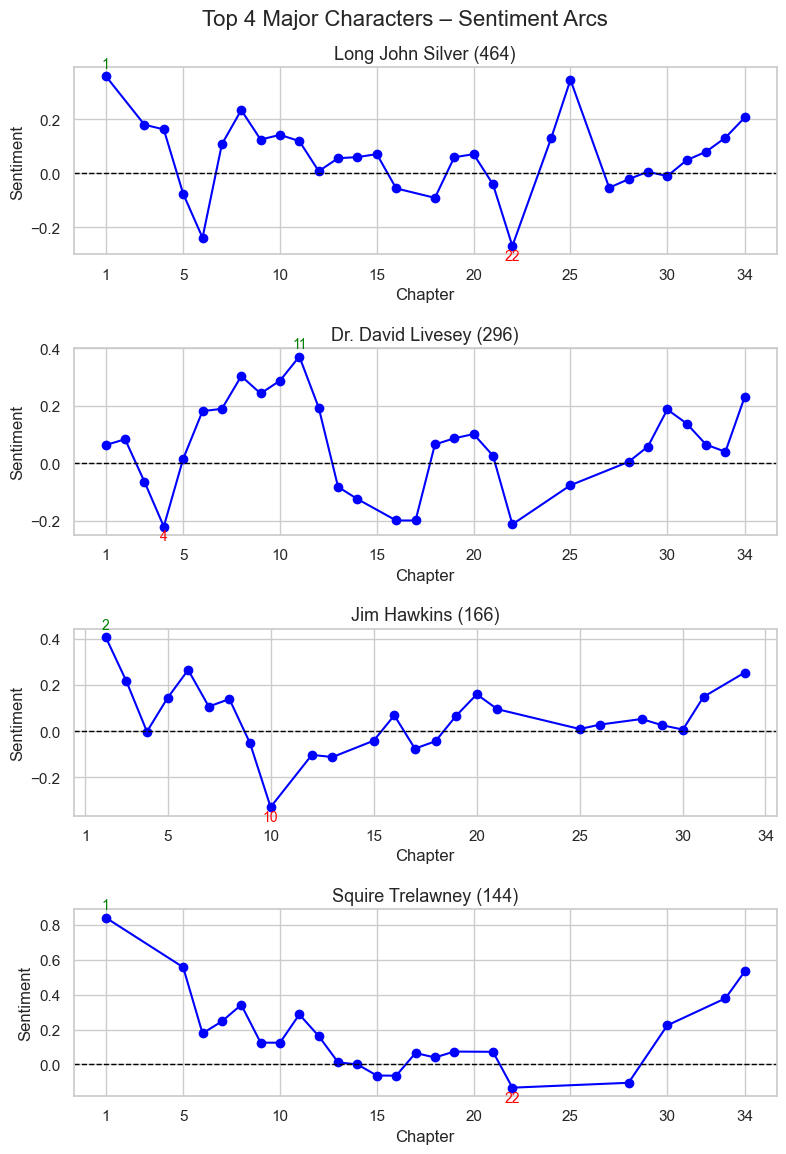

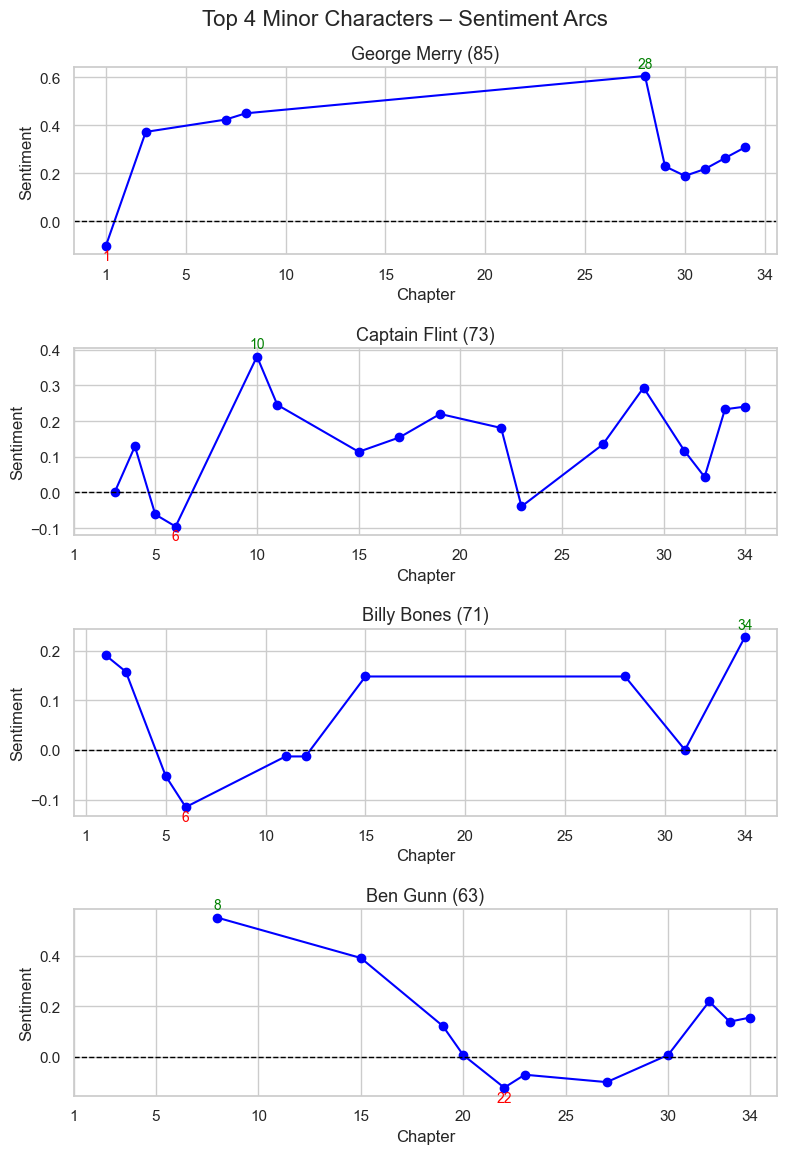

In [38]:
plot_character_sentiment_arcs(sentiment_by_chapter_df, major_characters, category_label="Major", top_n=4) # type: ignore
plot_character_sentiment_arcs(sentiment_by_chapter_df, minor_characters, category_label="Minor", top_n=4) # type: ignore


## Sentiment Volatility by Character

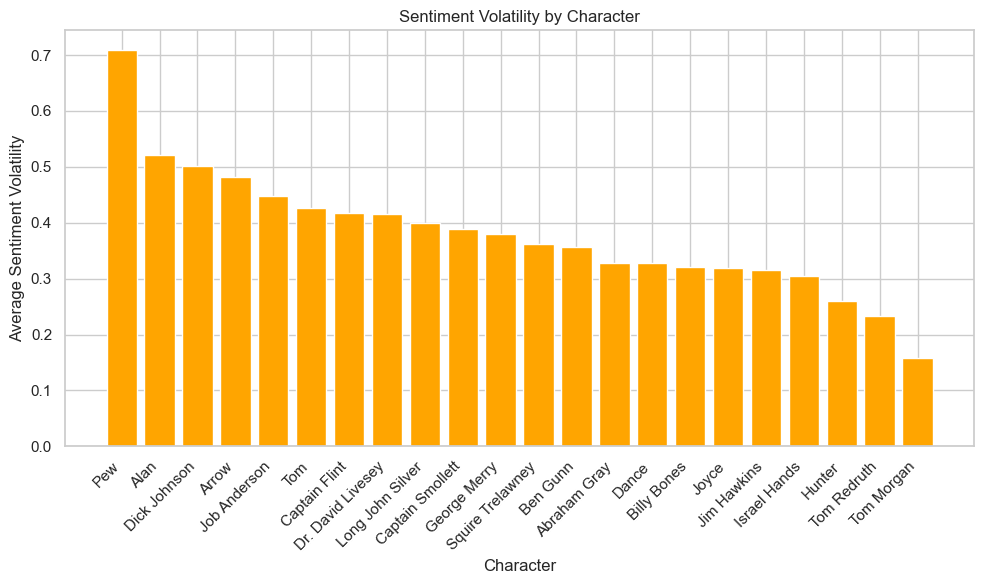

In [39]:

# Calculate sentiment volatility (standard deviation of sentiment per chapter for each character)
sentiment_volatility_df = (
    long_df.groupby(["Character", "Chapter"])["SentimentScore"]
    .std()  # Calculate standard deviation for each character per chapter
    .reset_index()
    .rename(columns={"SentimentScore": "SentimentVolatility"})
)

# Calculate the average sentiment volatility for each character across all chapters
average_volatility = sentiment_volatility_df.groupby("Character")["SentimentVolatility"].mean().reset_index()

# Sort characters by sentiment volatility (high to low)
sorted_volatility = average_volatility.sort_values("SentimentVolatility", ascending=False)

# Plot sentiment volatility for each character
plt.figure(figsize=(10, 6))

# Create a bar plot to visualize sentiment volatility for the top characters
plt.bar(sorted_volatility["Character"], sorted_volatility["SentimentVolatility"], color='orange')
plt.title('Sentiment Volatility by Character')
plt.xlabel('Character')
plt.ylabel('Average Sentiment Volatility')
plt.xticks(rotation=45, ha="right")
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


## Hero & Villain Analysis

In [22]:
from scipy.stats import gaussian_kde

## Hero & Villain Analysis
# Ensure 'character_mentions' is built correctly
character_mentions = long_df["Character"].value_counts().reset_index()
character_mentions.columns = ["Character", "MentionCount"]

# Calculate average sentiment
avg_sentiment = long_df.groupby("Character")["SentimentScore"].mean().reset_index()

# Calculate average volatility (std dev per character)
sentiment_volatility_df = (
    long_df.groupby(["Character", "Chapter"])["SentimentScore"]
    .std()
    .reset_index()
    .rename(columns={"SentimentScore": "SentimentVolatility"})
)
average_volatility = sentiment_volatility_df.groupby("Character")["SentimentVolatility"].mean().reset_index()

# Merge everything
role_df = avg_sentiment.merge(average_volatility, on="Character")
role_df = role_df.merge(character_mentions, on="Character")
role_df = role_df.rename(columns={
    "SentimentScore": "AvgSentiment",
    "SentimentVolatility": "SentimentStdDev",
    "MentionCount": "TotalMentions"
})


# Prepare data
data = role_df["SentimentStdDev"].dropna().values

# Compute KDE
kde = gaussian_kde(data)
x_vals = np.linspace(min(data), max(data), 1000)
y_vals = kde(x_vals)

# Identify KDE peak (mode)
peak_std = x_vals[np.argmax(y_vals)]
print(f"Peak (KDE Mode) of Sentiment Volatility = {peak_std:.4f}")


# Role classification function
def infer_refined_role(row):
    sentiment = row["AvgSentiment"]
    stddev = row["SentimentStdDev"]
    if sentiment >= 0 and stddev <= peak_std:
        return "Hero"
    elif sentiment < 0 and stddev >= peak_std:
        return "Villain"
    elif stddev >= peak_std:
        return "Morally Complex"
    else:
        return "Support/Neutral"

# Apply role logic
role_df["RefinedRole"] = role_df.apply(infer_refined_role, axis=1)

# Sort and display
role_df = role_df.sort_values("TotalMentions", ascending=False)
print("Final Role Classification Using Sharp Thresholds:\n")
print(role_df[["Character", "TotalMentions", "AvgSentiment", "SentimentStdDev", "RefinedRole"]].to_string(index=False))

#Stylish table for notebooks
try:
    display(
        role_df.style.set_properties(**{
            'border': '1px solid black',
            'font-size': '13pt'
        }).set_table_styles([{
            'selector': 'th',
            'props': [('font-size', '14pt'), ('background-color', '#f5f5f5')]
        }])
    )
except:
    pass


Peak (KDE Mode) of Sentiment Volatility = 0.3639
Final Role Classification Using Sharp Thresholds:

        Character  TotalMentions  AvgSentiment  SentimentStdDev     RefinedRole
 Long John Silver            464      0.055722         0.399719 Morally Complex
Dr. David Livesey            296      0.074463         0.415162 Morally Complex
      Jim Hawkins            166      0.093355         0.315018            Hero
 Squire Trelawney            144      0.103722         0.362811            Hero
 Captain Smollett            115      0.013473         0.389426 Morally Complex
     George Merry             85      0.271321         0.380635 Morally Complex
    Captain Flint             73      0.076849         0.416986 Morally Complex
      Billy Bones             71     -0.049294         0.321610 Support/Neutral
         Ben Gunn             63      0.073659         0.356478            Hero
     Abraham Gray             55      0.120609         0.327852            Hero
     Dick Johnson   

,Character,AvgSentiment,SentimentStdDev,TotalMentions,RefinedRole
16,Long John Silver,0.055722,0.399719,464,Morally Complex
9,Dr. David Livesey,0.074463,0.415162,296,Morally Complex
13,Jim Hawkins,0.093355,0.315018,166,Hero
18,Squire Trelawney,0.103722,0.362811,144,Hero
6,Captain Smollett,0.013473,0.389426,115,Morally Complex
10,George Merry,0.271321,0.380635,85,Morally Complex
5,Captain Flint,0.076849,0.416986,73,Morally Complex
4,Billy Bones,-0.049294,0.321610,71,Support/Neutral
3,Ben Gunn,0.073659,0.356478,63,Hero
0,Abraham Gray,0.120609,0.327852,55,Hero


Peak (KDE Mode) of Sentiment Volatility = 0.3639


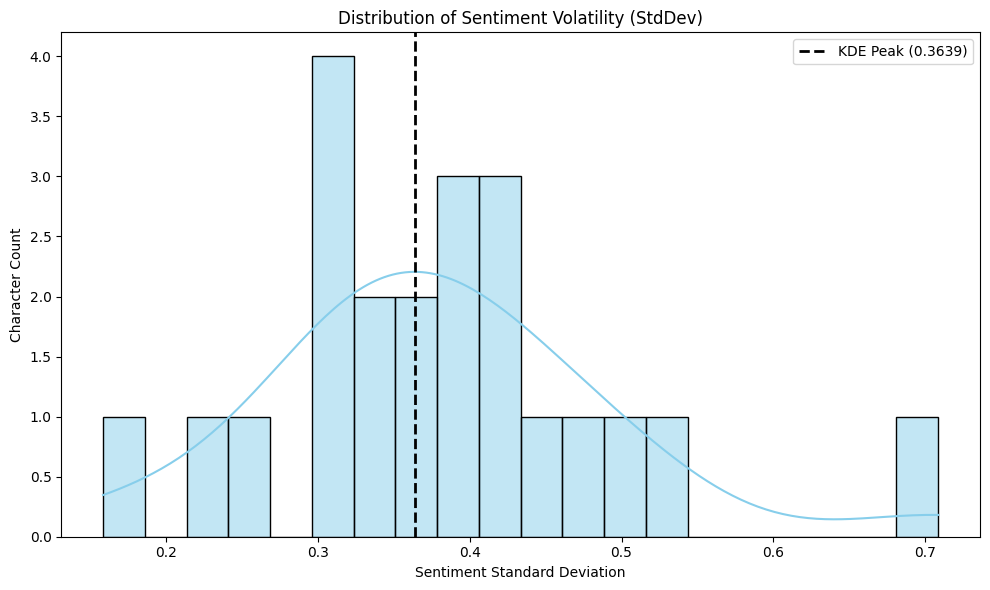

In [23]:
from scipy.stats import gaussian_kde
# Prepare data
data = role_df["SentimentStdDev"].dropna().values

# Compute KDE
kde = gaussian_kde(data)
x_vals = np.linspace(min(data), max(data), 1000)
y_vals = kde(x_vals)

# Identify KDE peak (mode)
peak_std = x_vals[np.argmax(y_vals)]
print(f"Peak (KDE Mode) of Sentiment Volatility = {peak_std:.4f}")

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=20, color='skyblue')

# Add vertical line at KDE peak
plt.axvline(peak_std, color='black', linestyle='--', linewidth=2, label=f"KDE Peak ({peak_std:.4f})")

# Final touches
plt.title("Distribution of Sentiment Volatility (StdDev)")
plt.xlabel("Sentiment Standard Deviation")
plt.ylabel("Character Count")
plt.legend()
plt.tight_layout()
plt.show()


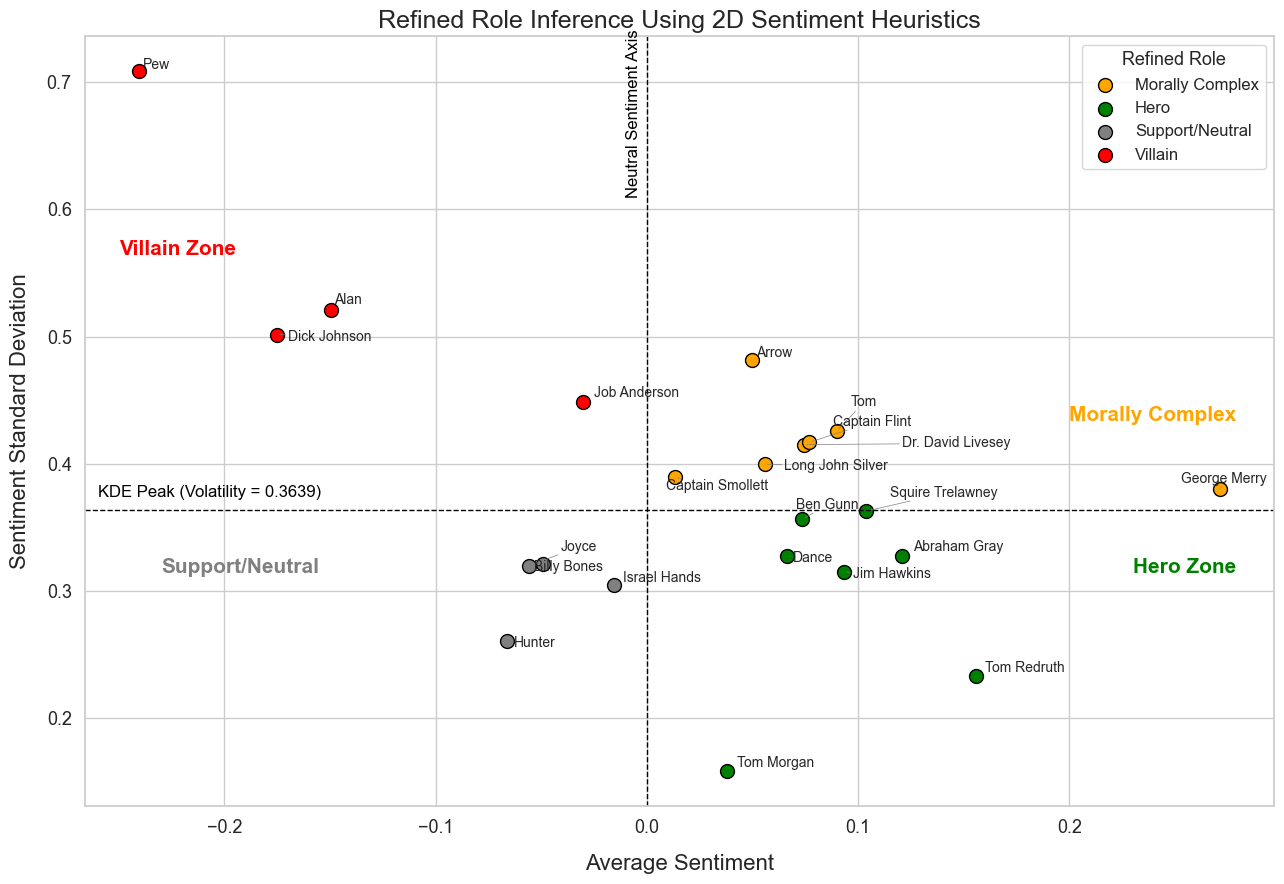

In [42]:
from adjustText import adjust_text

plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set(style="whitegrid")

# Compute KDE-based peak of StdDev
data = role_df["SentimentStdDev"].dropna().values
kde = gaussian_kde(data)
x_vals = np.linspace(min(data), max(data), 1000)
y_vals = kde(x_vals)
peak_std = x_vals[np.argmax(y_vals)]

# Set up figure
plt.figure(figsize=(13, 9))

# Color mapping for roles
color_map = {
    "Hero": "green",
    "Villain": "red",
    "Morally Complex": "orange",
    "Support/Neutral": "gray"
}

# Scatter plot by role
for role in role_df["RefinedRole"].unique():
    subset = role_df[role_df["RefinedRole"] == role]
    plt.scatter(
        subset["AvgSentiment"],
        subset["SentimentStdDev"],
        label=role,
        c=color_map[role],
        s=100,
        edgecolors='black'
    )

# Label selected characters
texts = []
for _, row in role_df.iterrows():
    texts.append(plt.text(
        row["AvgSentiment"],
        row["SentimentStdDev"],
        row["Character"],
        fontsize=10
    ))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Threshold lines
plt.axhline(peak_std, color="black", linestyle="--", linewidth=1)
plt.axvline(0.0, color="black", linestyle="--", linewidth=1)

# Axis label formatting
plt.xlabel("Average Sentiment", fontsize=16, labelpad=12)
plt.ylabel("Sentiment Standard Deviation", fontsize=16, labelpad=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Threshold annotations
plt.text(-0.26, peak_std + 0.01, f"KDE Peak (Volatility = {peak_std:.4f})", fontsize=12, color="black")
plt.text(-0.01, plt.ylim()[1] - 0.125, "Neutral Sentiment Axis", rotation=90, fontsize=12, color="black")

# Zone labels - now bold and larger
plt.text(-0.25, peak_std + 0.2, "Villain Zone", fontsize=15, color="red", weight='bold')
plt.text(0.2, peak_std + 0.07, "Morally Complex", fontsize=15, color="orange", weight='bold')
plt.text(0.23, peak_std - 0.05, "Hero Zone", fontsize=15, color="green", weight='bold')
plt.text(-0.23, peak_std - 0.05, "Support/Neutral", fontsize=15, color="gray", weight='bold')

# Final touches
plt.title("Refined Role Inference Using 2D Sentiment Heuristics", fontsize=18)
plt.legend(title="Refined Role", fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()
